## Importacion de librerias y lectura de datos preprocesados

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [91]:
# load preprocess datasets
path = '../../data/processed/'

wine_data = pd.read_csv(
    os.path.join(path, "wine_pro.csv")
)
eto_data = pd.read_csv(
    os.path.join(path, "eto_pro.csv")
)
meteo_data = pd.read_csv(
    os.path.join(path, "meteo_pro.csv")
)

In [92]:
wine_data.columns

Index(['campana', 'id_finca', 'id_zona', 'id_estacion', 'altitud', 'variedad',
       'modo', 'tipo', 'color', 'superficie', 'produccion',
       'sup_tot_camp_finca', 'superficie_total', 'n_var_camp_finca'],
      dtype='object')

In [5]:
eto_data.columns

Index(['year', 'ID_ESTACION', 'GustLocalDayAvgMonth1', 'GustLocalDayAvgMonth2',
       'GustLocalDayAvgMonth3', 'GustLocalDayAvgMonth4',
       'GustLocalDayAvgMonth5', 'GustLocalDayAvgMonth6',
       'MSLPLocalDayAvgMonth1', 'MSLPLocalDayAvgMonth2',
       'MSLPLocalDayAvgMonth3', 'MSLPLocalDayAvgMonth4',
       'MSLPLocalDayAvgMonth5', 'MSLPLocalDayAvgMonth6',
       'RelativeHumidityLocalDayAvgMonth1',
       'RelativeHumidityLocalDayAvgMonth2',
       'RelativeHumidityLocalDayAvgMonth3',
       'RelativeHumidityLocalDayAvgMonth4',
       'RelativeHumidityLocalDayAvgMonth5',
       'RelativeHumidityLocalDayAvgMonth6', 'UVIndexLocalDayAvgMonth1',
       'UVIndexLocalDayAvgMonth2', 'UVIndexLocalDayAvgMonth3',
       'UVIndexLocalDayAvgMonth4', 'UVIndexLocalDayAvgMonth5',
       'UVIndexLocalDayAvgMonth6', 'VisibilityLocalDayAvgMonth1',
       'VisibilityLocalDayAvgMonth2', 'VisibilityLocalDayAvgMonth3',
       'VisibilityLocalDayAvgMonth4', 'VisibilityLocalDayAvgMonth5',
       'Visib

In [6]:
meteo_data.columns

Index(['ID_ESTACION', 'year', 'max_12_to_16_temp_month_1',
       'max_12_to_16_temp_month_2', 'max_12_to_16_temp_month_3',
       'max_12_to_16_temp_month_4', 'max_12_to_16_temp_month_5',
       'max_12_to_16_temp_month_6', 'min_1_to_5_temp_month_1',
       'min_1_to_5_temp_month_2', 'min_1_to_5_temp_month_3',
       'min_1_to_5_temp_month_4', 'min_1_to_5_temp_month_5',
       'min_1_to_5_temp_month_6'],
      dtype='object')

## Join de datasets

In [93]:
# join datasets
eto_data['year'] = eto_data.year%2000
meteo_data['year'] = meteo_data.year%2000

In [94]:
meteo_full = eto_data.merge(
    meteo_data,
    left_on=['ID_ESTACION','year'],
    right_on=['ID_ESTACION','year'],
)

In [95]:
data_full = wine_data.merge(
    meteo_full,
    left_on = ["id_estacion","campana"],
    right_on = ['ID_ESTACION',"year"],
    how='left',
).drop(columns=['ID_ESTACION',"year"])

## Fill NA para 2014?

In [96]:
for col in eto_data.columns[2:].to_list() + meteo_data.columns[2:].to_list():
    data_full[col] = data_full.groupby(['id_estacion'])[col].transform(lambda x: x.fillna(x.mean()))


In [97]:
for col in eto_data.columns[2:].to_list() + meteo_data.columns[2:].to_list():
    data_full[col] = data_full[col].transform(lambda x: x.fillna(x.mean()))


## Modelos

In [98]:
data_test = data_full[data_full['campana']==22]
data = data_full[data_full['campana']<22] 

In [99]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import category_encoders as ce
from xgboost import XGBRegressor
from typing import List, Tuple
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import GroupKFold, KFold
from sklearn.base import clone
from catboost import CatBoostRegressor
seed = 42

In [100]:
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def eval_model(m, X, y, train_test_idx:List[Tuple[pd.Series,pd.Series]]):
    res = {
        "rmse":[],
        "mape":[],
    }
    for idxs in train_test_idx:
        m_ = clone(m)
        train_idx, test_idx = idxs[0], idxs[1]
        X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        m_.fit(X_train, y_train)
        y_pred = m_.predict(X_test)
        mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
        rmse = rmse_score(y_true=y_test, y_pred=y_pred)
        res['mape'].append(mape)
        res['rmse'].append(rmse)
    return res

In [101]:

X = data.drop(columns="produccion")
y = data['produccion']
train_idx, test_idx =  X['campana']!=21, X['campana']==21
train_idx2, test_idx2 =  X['campana']!=20, X['campana']==20
train_idx3, test_idx3 =  X['campana']!=19, X['campana']==19
train_test_idx = [(train_idx, test_idx),(train_idx2, test_idx2), (train_idx3, test_idx3)]
print(X.shape, y.shape)

(8526, 97) (8526,)


Linear regression

In [102]:
# baseline
m = make_pipeline(
    StandardScaler(), 
    LinearRegression()
)

eval_model(
    m = m,
    X = X[['superficie']],
    y = y,
    train_test_idx = train_test_idx
)

{'rmse': [9304.04579478326, 9604.170782556743, 7216.98985808023],
 'mape': [14.508420654744619, 7.573869686056191, 4.91781832612702]}

Linear regression con cat cols ordinal encoders

In [103]:
wine_cols = [
    'campana','id_finca','id_zona',
    'id_estacion','superficie','altitud',
    "variedad","modo","tipo",
    "color",'sup_tot_camp_finca',
    'superficie_total','n_var_camp_finca'
]

cat_cols = [
    'id_finca','id_zona',
    'id_estacion','variedad',
    "modo","tipo","color"
]

X[cat_cols] = X[cat_cols].astype("category")

In [20]:
wine_cols = [
    'campana','id_finca','id_zona',
    'id_estacion','superficie','altitud',
    "variedad","modo","tipo",
    "color",'sup_tot_camp_finca',
    'superficie_total','n_var_camp_finca'
]

cat_cols = [
    'id_finca','id_zona',
    'id_estacion','variedad',
    "modo","tipo","color"
]

X[cat_cols] = X[cat_cols].astype("category")


prep = make_column_transformer(
    (ce.OrdinalEncoder(), cat_cols),
    # (ce.TargetEncoder(), cat_cols),
    # (ce.CountEncoder(), cat_cols),
    # (ce.GLMMEncoder(), cat_cols),
    # (ce.QuantileEncoder(), cat_cols),
    # (ce.BaseNEncoder(), cat_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep, 
    StandardScaler(),
    LinearRegression()
)

eval_model(
    m = m,
    X = X[wine_cols],
    y = y,
    train_test_idx = train_test_idx
)

{'rmse': [9099.67328093734, 9107.699653839534, 6889.486836936577],
 'mape': [8.792865747310477, 2.6940488441777726, 2.0849724386181587]}

Random forest con ordinal encoder

In [104]:
# more base features
prep = make_column_transformer(
    (ce.OrdinalEncoder(), cat_cols),
    # (ce.TargetEncoder(), cat_cols),
    # (ce.CountEncoder(), cat_cols),
    # (ce.GLMMEncoder(), cat_cols),
    # (ce.QuantileEncoder(), cat_cols),
    # (ce.BaseNEncoder(), cat_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep, 
    RandomForestRegressor(random_state=seed)
)

eval_model(
    m = m,
    X = X[wine_cols],
    y = y,
    train_test_idx = train_test_idx
)

# {'rmse': [5558.049335489552, 6366.950211490536, 5830.889563548889],
#  'mape': [6.837990608558632, 0.85553702417759, 0.7554832255857427]}

{'rmse': [5634.371714641351, 6429.908316254829, 5700.591498556989],
 'mape': [5.29776973921714, 0.9669608084836333, 0.642672753102016]}

CatBoost - No lleva transformaciones porque usa categoricas

In [25]:
eval_model(
    m = CatBoostRegressor(random_state=seed, cat_features=cat_cols, verbose=0),
    X = X[wine_cols],
    y = y,
    train_test_idx = train_test_idx
)

#{'rmse': [5804.828371423887, 6527.78062513723, 5220.828341127418],
 #'mape': [8.420494123028638, 1.5154458577347376, 1.0728977587267101]}

{'rmse': [5804.828371423887, 6527.78062513723, 5220.828341127418],
 'mape': [8.420494123028638, 1.5154458577347376, 1.0728977587267101]}

Con ETO

In [26]:
# more base features
eto_cols = X.columns[X.columns.str.contains("Month")].to_list()

prep = make_column_transformer(
    (ce.OrdinalEncoder(), cat_cols),
    # (ce.TargetEncoder(), cat_cols),
    # (ce.CountEncoder(), cat_cols),
    # (ce.GLMMEncoder(), cat_cols),
    # (ce.QuantileEncoder(), cat_cols),
    # (ce.BaseNEncoder(), cat_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep, 
    RandomForestRegressor(random_state=seed, n_jobs=-1)
)

eval_model(
    m = m,
    X = X[wine_cols+eto_cols],
    y = y,
    train_test_idx = train_test_idx
)

{'rmse': [7453.488871680028, 7788.294754551616, 5519.93004146904],
 'mape': [15.510885915605234, 3.122703665051877, 3.2142197794511658]}

Con Meteo

In [27]:
meteo_cols = X.columns[X.columns.str.contains("month")].to_list()

prep = make_column_transformer(
    (ce.OrdinalEncoder(), cat_cols),
    # (ce.TargetEncoder(), cat_cols),
    # (ce.CountEncoder(), cat_cols),
    # (ce.GLMMEncoder(), cat_cols),
    # (ce.QuantileEncoder(), cat_cols),
    # (ce.BaseNEncoder(), cat_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep, 
    RandomForestRegressor(random_state=seed, n_jobs=-1)
)


eval_model(
    m = m,
    X = X[wine_cols+meteo_cols],
    y = y,
    train_test_idx = train_test_idx
)

{'rmse': [7028.966886276845, 7325.792206720342, 4936.93101361699],
 'mape': [5.841791489127073, 3.826357818335276, 0.8869244937439578]}

Con PCA

<AxesSubplot: >

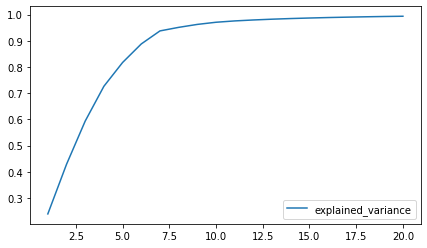

In [29]:
from sklearn.decomposition import PCA

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X[eto_cols+meteo_cols])

n_comps = 20
pca = PCA(n_components=n_comps)
pca.fit(
    X_scaled
)
pd.DataFrame(
    np.cumsum(pca.explained_variance_ratio_),
    index=range(1,n_comps+1),
    columns=['explained_variance']
).plot(figsize=(7,4))

In [30]:
wine_num_cols = [c for c in wine_cols if c not in cat_cols]

prep = make_column_transformer(
    (ce.OrdinalEncoder(), cat_cols),
    # (ce.TargetEncoder(), cat_cols),
    # (ce.CountEncoder(), cat_cols),
    # (ce.GLMMEncoder(), cat_cols),
    # (ce.QuantileEncoder(), cat_cols),
    # (ce.BaseNEncoder(), cat_cols),
    (PCA(n_components=7), meteo_cols+eto_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep, 
    RandomForestRegressor(random_state=seed, n_jobs=-1)
)

eval_model(
    m = m,
    X = X[wine_cols+meteo_cols+eto_cols],
    y = y,
    train_test_idx = train_test_idx
)

{'rmse': [6743.522879449096, 7353.510196777592, 4694.264480070661],
 'mape': [5.859867782360078, 2.5718660317518536, 0.8447165614538779]}

Probar encoders

In [88]:
wine_cols = [
    'campana','id_finca','id_zona',
    'id_estacion','superficie','altitud',
    "variedad","modo","tipo",
    "color",'sup_tot_camp_finca',
    'superficie_total','n_var_camp_finca'
]

cat_cols = [
    'id_finca','id_zona',
    'id_estacion','variedad',
    "modo","tipo","color","altitud"
]

X[cat_cols] = X[cat_cols].astype("category")

wine_num_cols = [c for c in wine_cols if c not in cat_cols]

In [89]:
glm_cols = [
    'id_finca',
    'id_zona',
    'id_estacion'
]

ord_cols = [
    'modo', 
    'tipo', 
    'color'
]

rest_cat_cols = [
    'variedad','altitud'
]

prep = make_column_transformer(
    # (ce.CountEncoder(), rest_cat_cols),
    # (ce.BaseNEncoder(), rest_cat_cols),
    # (ce.QuantileEncoder(), rest_cat_cols),
    (ce.TargetEncoder(), rest_cat_cols),
    (ce.OrdinalEncoder(), ord_cols),
    (ce.GLMMEncoder(), glm_cols),
    # (PCA(n_components=3), meteo_cols+eto_cols),
    (StandardScaler(), wine_num_cols),
    # remainder='passthrough'
    remainder='drop'
)


m = make_pipeline(
    prep, 
    CatBoostRegressor(random_state=seed,iterations=500,
                    #   cat_features=rest_cat_cols,
                     verbose=0),
    # XGBRegressor(random_state=seed, n_jobs=-1)
)

final_cols = wine_num_cols+glm_cols+rest_cat_cols+meteo_cols+eto_cols+ord_cols

eval_model(
    m = m,
    X = X[final_cols],
    y = y,
    train_test_idx = train_test_idx
)

KeyError: "['visibility', 'mslp', 'windspeed', 'totalprecipamountlocalday', 'uvindex', 'totalsnowamountlocalday', 'humidity', 'totalsnowamountlocalnight', 'totalprecipamountlocalnight', 'gust'] not in index"

In [455]:
X_ = prep.fit_transform(X[final_cols], y)
rf = RandomForestRegressor(random_state=seed, n_jobs=-1).fit(X_, y)

In [456]:
fno = []
for t in prep.named_transformers_:
    if t !='remainder':
        fno+=[f"{t}_{c}" for c in prep.named_transformers_[t].get_feature_names_out()]

In [461]:
len(fno + wine_num_cols,), X_.shape

(37, (8526, 37))

In [462]:
pd.DataFrame(
    rf.feature_importances_,
    index=fno + wine_num_cols,
    columns=['feat_imp']
).sort_values('feat_imp', ascending=False)
# .plot(kind='barh', figsize=(5,15))

,feat_imp
superficie,0.602510
glmmencoder_id_zona,0.067653
altitud,0.054365
superficie_total,0.032983
pca_pca0,0.025221
sup_tot_camp_finca,0.025143
pca_pca3,0.020847
pca_pca1,0.018039
pca_pca4,0.015390
glmmencoder_id_estacion,0.014715


In [419]:
# https://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.html

glmenc = ce.GLMMEncoder()
finca_trans = glmenc.fit_transform(X[['id_finca']], y)

x = X[['id_finca']] 
x['id_finca_enc']=finca_trans



In [422]:
pd.concat([x,y],axis=1)

,id_finca,id_finca_enc,produccion
0,76953,6628.287246,22215.0
1,84318,6628.287246,22215.0
2,85579,6077.803028,20978.0
3,69671,14864.189778,40722.0
4,14001,2142.153956,14126.0
...,...,...,...
8521,37461,20101.286633,28160.1
8522,58769,27953.986884,41310.0
8523,58769,27953.986884,45420.0
8524,88928,20780.209822,56140.0


### Transformaciones Denis

In [39]:
#Denis functions 

def df_for_fe(data):
    transf = data[data.campana != 21]
    return transf

def above_mean_col(data,col):
    df = df_for_fe(data)
    above_mean = pd.DataFrame(df.groupby(col)['produccion'].mean() > df.produccion.mean())
    above_mean = list(above_mean[above_mean['produccion']].index)
    data[f'{col}_above_mean'] = [1 if x in above_mean else 0 for x in data[col]]
    return data

def quantiles_col(data,col):
    df = df_for_fe(data)
    quantiles_df = pd.DataFrame(df.groupby(col)['produccion'].mean()).reset_index()
    Q1 = quantiles_df.produccion.quantile(0.25)
    Q2 = quantiles_df.produccion.quantile(0.5)
    Q3 = quantiles_df.produccion.quantile(0.75)
    
    quantiles_df[f'{col}_percentiles'] = [0 if x < Q1 else 1 if x < Q2 else 2 if x < Q3 else 3 for x in quantiles_df.produccion]

    data = data.merge(quantiles_df[[col,f'{col}_percentiles']], how='left', on = col) #Joineamos con el df transformado
    
    return data

In [45]:
data_models = data.copy()

for col in ['altitud','variedad']:
    data_models=above_mean_col(data_models,col)
    data_models.drop(columns=[col],inplace=True)
    
for col in ['id_finca','id_zona','id_estacion']:
    data_models=quantiles_col(data_models,col)
    data_models.drop(columns=[col],inplace=True)

data_models.head()

,campana,modo,tipo,color,superficie,produccion,sup_tot_camp_finca,superficie_total,n_var_camp_finca,GustLocalDayAvgMonth1,...,min_1_to_5_temp_month_2,min_1_to_5_temp_month_3,min_1_to_5_temp_month_4,min_1_to_5_temp_month_5,min_1_to_5_temp_month_6,altitud_above_mean,variedad_above_mean,id_finca_percentiles,id_zona_percentiles,id_estacion_percentiles
0,14,2,0,1,-1.0,22215.0,-1.0,-1.0,1,9.101671,...,0.439667,1.547141,3.586520,6.849317,12.805929,0,1,3.0,3.0,3
1,14,2,0,1,-1.0,22215.0,-1.0,-1.0,1,9.101671,...,0.439667,1.547141,3.586520,6.849317,12.805929,0,1,3.0,3.0,3
2,14,2,0,1,-1.0,20978.0,-1.0,-1.0,1,9.101671,...,0.439667,1.547141,3.586520,6.849317,12.805929,1,1,3.0,3.0,3
3,14,2,0,1,-1.0,40722.0,-1.0,-1.0,1,9.101671,...,0.439667,1.547141,3.586520,6.849317,12.805929,1,1,3.0,3.0,3
4,14,1,0,1,-1.0,14126.0,-1.0,-1.0,1,9.253947,...,-0.395643,0.611782,2.426411,5.947980,12.240739,1,0,3.0,1.0,2


In [62]:
data_models['id_finca_percentiles'] = data_models['id_finca_percentiles'].fillna(df_for_fe(data_models).id_finca_percentiles.mean())
data_models['id_zona_percentiles'] = data_models['id_zona_percentiles'].fillna(df_for_fe(data_models).id_zona_percentiles.mean())

In [64]:
X = data_models.drop(columns="produccion")
y = data_models['produccion']
train_idx, test_idx =  X['campana']!=21, X['campana']==21
train_idx2, test_idx2 =  X['campana']!=20, X['campana']==20
train_idx3, test_idx3 =  X['campana']!=19, X['campana']==19
train_test_idx = [(train_idx, test_idx),(train_idx2, test_idx2), (train_idx3, test_idx3)]
print(X.shape, y.shape)

(8526, 97) (8526,)


In [66]:
# more base features

wine_cols = [
    'campana','superficie',"modo","tipo",
    "color",'sup_tot_camp_finca',
    'superficie_total','n_var_camp_finca'
]

new_cols = ['altitud_above_mean',
            'variedad_above_mean',
            'id_finca_percentiles', 
            'id_zona_percentiles', 
            'id_estacion_percentiles'
]

cat_cols = [
    "modo","tipo","color"
]

X[cat_cols] = X[cat_cols].astype("category")

wine_num_cols = [c for c in wine_cols if c not in cat_cols]

prep = make_column_transformer(
    (ce.OrdinalEncoder(), cat_cols),
    # (ce.TargetEncoder(), cat_cols),
    # (ce.CountEncoder(), cat_cols),
    # (ce.GLMMEncoder(), cat_cols),
    # (ce.QuantileEncoder(), cat_cols),
    # (ce.BaseNEncoder(), cat_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep, 
    RandomForestRegressor(random_state=seed)
)

eval_model(
    m = m,
    X = X[wine_cols+new_cols],
    y = y,
    train_test_idx = train_test_idx
)

{'rmse': [5701.0075657539555, 6663.474455630962, 5642.332239413756],
 'mape': [5.264740417267263, 0.8611795036749608, 0.6345985039392481]}

In [67]:

#Eto annuals

def eto_dict_generator(df):
    temp_strings = ['gust','mslp','humidity','uvindex','visibility','windspeed',
                    'lluvia_daytime','lluvia_night','nieve_day','nieve_night',
                    'totalprecipamountlocalday','totalprecipamountlocalnight',
                    'totalsnowamountlocalday','totalsnowamountlocalnight']
    dic_temp = {}
    for string in temp_strings:
        columns = [col for col in df.columns if string in col]
        dic_temp[string] = columns
    return dic_temp


def eto_annual_sum(df,cols_list):
    dictionary = eto_dict_generator(df)
    dictionary = {key: dictionary[key] for key in cols_list}
    for name, data in dictionary.items():
            df[name] = df[data].sum(axis=1)
            df = df.drop(columns=data)
    return df

def eto_annual_mean(df,cols_list):
    dictionary = eto_dict_generator(df)
    dictionary = {key: dictionary[key] for key in cols_list}
    for name, data in dictionary.items():
            df[name] = df[data].mean(axis=1)
            df = df.drop(columns=data)
    return df

#Meteo annuals

def meteo_dict_generator(df):
    temp_strings = ['max_12_to_16','min_1_to_5']
    dic_temp = {}
    for string in temp_strings:
        columns = [col for col in df.columns if string in col]
        dic_temp[string] = columns
    return dic_temp


def meteo_annual_sum(df,cols_list):
    dictionary = meteo_dict_generator(df)
    dictionary = {key: dictionary[key] for key in cols_list}
    for name, data in dictionary.items():
            df[name] = df[data].sum(axis=1)
            df = df.drop(columns=data)
    return df

def meteo_annual_mean(df,cols_list):
    dictionary = meteo_dict_generator(df)
    dictionary = {key: dictionary[key] for key in cols_list}
    for name, data in dictionary.items():
            df[name] = df[data].mean(axis=1)
            df = df.drop(columns=data)
    return df

In [68]:
sum_cols = ['gust','totalprecipamountlocalday','totalprecipamountlocalnight',
                    'totalsnowamountlocalday','totalsnowamountlocalnight']
mean_cols = ['mslp','humidity','uvindex','visibility','windspeed']

In [69]:
data_eto = data_models.copy()
data_eto.columns = [col.lower() for col in data_eto.columns]
data_eto = eto_annual_sum(data_eto,sum_cols)
data_eto = eto_annual_mean(data_eto,mean_cols)
data_eto.head()

,campana,modo,tipo,color,superficie,produccion,sup_tot_camp_finca,superficie_total,n_var_camp_finca,temperaturelocalafternoonavgmonth1,...,gust,totalprecipamountlocalday,totalprecipamountlocalnight,totalsnowamountlocalday,totalsnowamountlocalnight,mslp,humidity,uvindex,visibility,windspeed
0,14,2,0,1,-1.0,22215.0,-1.0,-1.0,1,284.678545,...,50.841795,143.936580,142.139832,0.044026,0.01975,101790.042279,65.872321,1.344107,12795.279269,3.137330
1,14,2,0,1,-1.0,22215.0,-1.0,-1.0,1,284.678545,...,50.841795,143.936580,142.139832,0.044026,0.01975,101790.042279,65.872321,1.344107,12795.279269,3.137330
2,14,2,0,1,-1.0,20978.0,-1.0,-1.0,1,284.678545,...,50.841795,143.936580,142.139832,0.044026,0.01975,101790.042279,65.872321,1.344107,12795.279269,3.137330
3,14,2,0,1,-1.0,40722.0,-1.0,-1.0,1,284.678545,...,50.841795,143.936580,142.139832,0.044026,0.01975,101790.042279,65.872321,1.344107,12795.279269,3.137330
4,14,1,0,1,-1.0,14126.0,-1.0,-1.0,1,283.290910,...,51.730648,142.438764,139.810298,0.064782,0.03029,101791.242559,66.166475,1.345868,12708.736694,3.399462


In [70]:
X = data_eto.drop(columns="produccion")
y = data_eto['produccion']
train_idx, test_idx =  X['campana']!=21, X['campana']==21
train_idx2, test_idx2 =  X['campana']!=20, X['campana']==20
train_idx3, test_idx3 =  X['campana']!=19, X['campana']==19
train_test_idx = [(train_idx, test_idx),(train_idx2, test_idx2), (train_idx3, test_idx3)]
print(X.shape, y.shape)

(8526, 47) (8526,)


In [83]:
# more base features

wine_cols = [
    'campana','superficie',"modo","tipo",
    "color",'sup_tot_camp_finca',
    'superficie_total','n_var_camp_finca'
]

new_cols = ['altitud_above_mean',
            'variedad_above_mean',
            'id_finca_percentiles', 
            'id_zona_percentiles', 
            'id_estacion_percentiles'
]

eto_cols = ['gust', 'totalprecipamountlocalday',
       'totalprecipamountlocalnight', 'totalsnowamountlocalday',
       'totalsnowamountlocalnight', 'mslp', 'humidity', 'uvindex',
       'visibility', 'windspeed']

cat_cols = [
    "modo","tipo","color"
]

X[cat_cols] = X[cat_cols].astype("category")

wine_num_cols = [c for c in wine_cols if c not in cat_cols]

prep = make_column_transformer(
    (ce.OrdinalEncoder(), cat_cols),
    # (ce.TargetEncoder(), cat_cols),
    # (ce.CountEncoder(), cat_cols),
    # (ce.GLMMEncoder(), cat_cols),
    (ce.QuantileEncoder(), eto_cols),
    # (ce.BaseNEncoder(), cat_cols),
    # (PCA(n_components=2), eto_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep, 
    RandomForestRegressor(random_state=seed)
)

eval_model(
    m = m,
    X = X[wine_cols+new_cols+eto_cols],
    y = y,
    train_test_idx = train_test_idx
)

{'rmse': [6946.066843663072, 7608.5075623154125, 6732.93132757763],
 'mape': [8.527628464058717, 1.276032562341886, 1.0447713879234104]}

In [82]:
data_eto.corr()['produccion'].abs().sort_values(ascending=False)

produccion                            1.000000
superficie                            0.709180
superficie_total                      0.550752
sup_tot_camp_finca                    0.547514
id_finca_percentiles                  0.543400
id_zona_percentiles                   0.414280
altitud_above_mean                    0.302039
n_var_camp_finca                      0.295411
id_estacion_percentiles               0.276024
modo                                  0.271032
variedad_above_mean                   0.161318
temperaturelocalafternoonavgmonth5    0.105058
max_12_to_16_temp_month_4             0.098616
temperaturelocalafternoonavgmonth3    0.096374
temperaturelocalafternoonavgmonth4    0.089462
max_12_to_16_temp_month_3             0.072059
totalsnowamountlocalnight             0.066936
temperaturelocalovernightavgmonth3    0.061791
max_12_to_16_temp_month_6             0.061526
min_1_to_5_temp_month_4               0.058787
min_1_to_5_temp_month_3               0.057251
temperaturelo

In [75]:
data_meteo_eto = data_eto.copy()
data_meteo_eto.columns = [col.lower() for col in data_meteo_eto.columns]
data_meteo_eto = meteo_annual_mean(data_meteo_eto,['max_12_to_16','min_1_to_5'])
data_meteo_eto.head()

,campana,modo,tipo,color,superficie,produccion,sup_tot_camp_finca,superficie_total,n_var_camp_finca,temperaturelocalafternoonavgmonth1,...,totalprecipamountlocalnight,totalsnowamountlocalday,totalsnowamountlocalnight,mslp,humidity,uvindex,visibility,windspeed,max_12_to_16,min_1_to_5
0,14,2,0,1,-1.0,22215.0,-1.0,-1.0,1,284.678545,...,142.139832,0.044026,0.01975,101790.042279,65.872321,1.344107,12795.279269,3.137330,25.104666,3.745294
1,14,2,0,1,-1.0,22215.0,-1.0,-1.0,1,284.678545,...,142.139832,0.044026,0.01975,101790.042279,65.872321,1.344107,12795.279269,3.137330,25.104666,3.745294
2,14,2,0,1,-1.0,20978.0,-1.0,-1.0,1,284.678545,...,142.139832,0.044026,0.01975,101790.042279,65.872321,1.344107,12795.279269,3.137330,25.104666,3.745294
3,14,2,0,1,-1.0,40722.0,-1.0,-1.0,1,284.678545,...,142.139832,0.044026,0.01975,101790.042279,65.872321,1.344107,12795.279269,3.137330,25.104666,3.745294
4,14,1,0,1,-1.0,14126.0,-1.0,-1.0,1,283.290910,...,139.810298,0.064782,0.03029,101791.242559,66.166475,1.345868,12708.736694,3.399462,23.978794,2.862108


In [76]:
data_meteo_eto.columns

Index(['campana', 'modo', 'tipo', 'color', 'superficie', 'produccion',
       'sup_tot_camp_finca', 'superficie_total', 'n_var_camp_finca',
       'temperaturelocalafternoonavgmonth1',
       'temperaturelocalafternoonavgmonth2',
       'temperaturelocalafternoonavgmonth3',
       'temperaturelocalafternoonavgmonth4',
       'temperaturelocalafternoonavgmonth5',
       'temperaturelocalafternoonavgmonth6',
       'temperaturelocalovernightavgmonth1',
       'temperaturelocalovernightavgmonth2',
       'temperaturelocalovernightavgmonth3',
       'temperaturelocalovernightavgmonth4',
       'temperaturelocalovernightavgmonth5',
       'temperaturelocalovernightavgmonth6', 'altitud_above_mean',
       'variedad_above_mean', 'id_finca_percentiles', 'id_zona_percentiles',
       'id_estacion_percentiles', 'gust', 'totalprecipamountlocalday',
       'totalprecipamountlocalnight', 'totalsnowamountlocalday',
       'totalsnowamountlocalnight', 'mslp', 'humidity', 'uvindex',
       'visibility